In [1]:
%load_ext autoreload 
%autoreload 2
import sys 
sys.path.append('../3pvec_resampling')
import matplotlib.pyplot as plt
import numpy as np 
import nibabel 
from matplotlib.cm import get_cmap
import os.path as op 
import regtricks as rt 
import helpers
from scipy.ndimage import binary_erosion
from scipy import stats 
from shutil import copytree 
import toblerone as tob 
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
from run_svb_tests import N_REPEATS, SIM_ROOT
from run_svb_tests import ROI_CENTS, rois_flat
import string 

cmap = np.array(get_cmap('tab10').colors)
loadnii = lambda p: nibabel.load(str(p)).get_fdata()
FIGSIZE = 4

# generate random transforms 
# prepare projector in each native space, transform surfaces 
# simulate data, estimate perfusion (SVB vs projection of CBF map onto surface)
# map back into common space and analyse cbf 

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
proj_cmn = tob.Projector.load(op.join(SIM_ROOT, '../spatial_prior_tests/L_hemi_projector.h5'))
# lap = proj_cmn.mesh_laplacian()

In [3]:
surf = proj_cmn['LWS']
s2v = proj_cmn.surf2vol_matrix(False).tocsr()
verts_per_vox = (s2v > 0).sum(-1)
vox_idx = np.flatnonzero(verts_per_vox)[15457]

In [4]:
verts_idx = s2v[vox_idx,:].indices
ps = surf.transform(proj_cmn.spc.world2vox).points[:,:2]
enclosed = (ps[verts_idx,:].round() == [46,34]).all(-1)
enclosed = verts_idx[enclosed]
tris = np.flatnonzero(np.isin(surf.tris, enclosed).any(-1))
patch_tris = surf.tris[tris,:]
enclosed_tris = np.flatnonzero(np.isin(surf.tris, enclosed).all(-1))

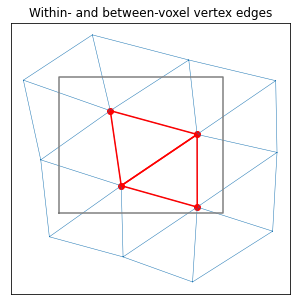

In [5]:
from matplotlib.tri.triangulation import Triangulation
from matplotlib.tri import triplot
fig, ax = plt.subplots(1,1,figsize=(5,5))
tri = Triangulation(ps[:,0], ps[:,1], triangles=surf.tris[tris,:])
triplot(ax, tri, linewidth=0.5)
ax.scatter(ps[enclosed,0], ps[enclosed,1], c='r')
for et in enclosed_tris: 
    x = ps[surf.tris[et,:],0]
    y = ps[surf.tris[et,:],1]
    ax.plot([*x,x[0]],[*y,y[0]],'r')

ax.plot([45.5,45.5,46.5,46.5,45.5], [33.5,34.5,34.5,33.5,33.5], c=cmap[7,:])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Within- and between-voxel vertex edges')
plt.savefig('figs/disc_lap_edges.png', dpi=250, bbox_inches='tight')
plt.show()

In [6]:
# Mean number of vertices per voxel
ps = surf.transform(proj_cmn.spc.world2vox).points.round().astype(np.int32)
idx = np.ravel_multi_index(ps.T, proj_cmn.spc.size)
u,c = np.unique(idx, return_counts=True)
c.mean()

3.4155366340796802

## Volumetric analysis (subcort WM)

In [7]:
from run_svb_tests import Q2, SIM_ROOT

root = op.join(SIM_ROOT, f'../spatial_prior_tests')
proj = tob.Projector.load(op.join(SIM_ROOT, 
               f'../spatial_prior_tests/svb_acquisition_noise_q2-10',
               'projector.h5'))
cbf = np.zeros((len(Q2), 2, 2))
att = np.zeros((len(Q2), 2, 2))

for q2_idx, q2 in enumerate(Q2):
    sdir = op.join(root, f'svb_acquisition_noise_q2-{q2}')
    c, a, _ = helpers.load_svb_hybrid(sdir)
    cbf[q2_idx,0,:] = [ c[1].mean(), c[1].std() ]
    att[q2_idx,0,:] = [ a[1].mean(), a[1].std() ]

    sdir = op.join(root, f'svb_parameter_noise_q2-{q2}')
    c, a, _= helpers.load_svb_hybrid(sdir)
    cbf[q2_idx,1,:] = [ c[1].mean(), c[1].std() ]
    att[q2_idx,1,:] = [ a[1].mean(), a[1].std() ]
    
cbf = 100 * cbf / 20 
att = 100 * att / 1.6 

In [8]:
# Load BASIL's results. We mask GM to the cortex only 
# and WM to the subcortex only 
ctx_mask = (proj.cortex_pvs()[...,0] > 0.05)
wm_mask = (proj.pvs()[...,1] > 0.05)
basil_cbf = np.zeros((2,2))
basil_att = np.zeros((2,2))

bdir = op.join(root, 'basil_acquisition_noise')
bc = helpers.load_basil(bdir, True)
ba = helpers.load_basil_att(bdir, True)
basil_cbf[0,:] = [ bc[wm_mask,1].mean(), bc[wm_mask,1].std() ] 
basil_att[0,:] = [ ba[wm_mask,1].mean(), ba[wm_mask,1].std() ]

bdir = op.join(root, 'basil_parameter_noise')
bc = helpers.load_basil(bdir, True)
ba = helpers.load_basil_att(bdir, True)
basil_cbf[1,:] = [ bc[wm_mask,1].mean(), bc[wm_mask,1].std() ] 
basil_att[1,:] = [ ba[wm_mask,1].mean(), ba[wm_mask,1].std() ]

basil_cbf = 100 * basil_cbf / 20
basil_att = 100 * basil_att / 1.6

In [9]:
qmap = get_cmap('plasma')

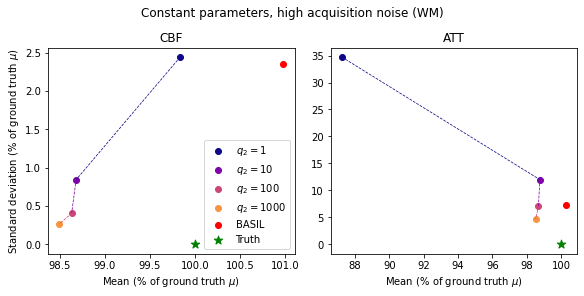

In [10]:
fig, axes = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)
fig.suptitle('Constant parameters, high acquisition noise (WM)')

for d, ax, b, t, gnd in zip([cbf[:,0,:],att[:,0,:]], axes, 
                       [basil_cbf[0,:], basil_att[0,:]], [r'CBF', 'ATT'],
                       [(100,0), (100,0)]):

    for qidx,q in enumerate(Q2):
        if qidx < len(Q2)-1:
            lx = d[qidx:qidx+2,0]
            ly = d[qidx:qidx+2,1]
            ax.plot(lx,ly, c=qmap((qidx)/len(Q2)), linestyle='--', linewidth=0.75)
        ax.scatter(x=d[qidx,0], y=d[qidx,1], label=fr'$q_2 = {q}$', c=[qmap((qidx)/len(Q2))])

    ax.scatter(*b, label='BASIL', c='r')
    ax.scatter(*gnd, label='Truth', c='g', marker='*', s=80)
    ax.set_title(t)
    ax.set_xlabel(r'Mean (% of ground truth $\mu$)')
    
axes[0].set_ylabel(r'Standard deviation (% of ground truth $\mu$)')
axes[0].legend()
plt.savefig('figs/acquisition_noise.png', dpi=250, bbox_inches='tight')
plt.show()

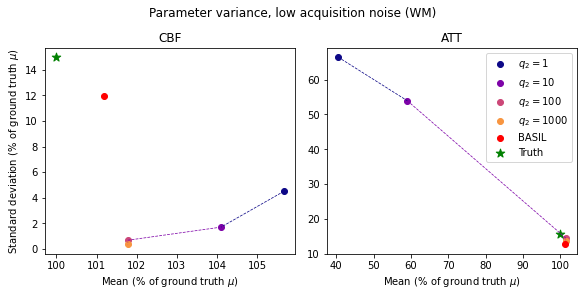

In [11]:
fig, axes = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)
fig.suptitle('Parameter variance, low acquisition noise (WM)')

for d, ax, b, t, gnd in zip([cbf[:,1,:],att[:,1,:]], axes, 
                        [basil_cbf[1,:], basil_att[1,:]], [r'CBF', 'ATT'],
                        [(100,3*100/20), (100,100*0.25/1.6)]):

    for qidx,q in enumerate(Q2):
        if qidx < len(Q2)-1:
            lx = d[qidx:qidx+2,0]
            ly = d[qidx:qidx+2,1]
            ax.plot(lx,ly, c=qmap((qidx)/len(Q2)), linestyle='--', linewidth=0.75)
        ax.scatter(x=d[qidx,0], y=d[qidx,1], label=fr'$q_2 = {q}$', c=[qmap((qidx)/len(Q2))])

    ax.scatter(*b, label='BASIL', c='r')
    ax.scatter(*gnd, label='Truth', c='g', marker='*', s=80)
    ax.set_title(t)
    ax.set_xlabel(r'Mean (% of ground truth $\mu$)')
    
axes[0].set_ylabel(r'Standard deviation (% of ground truth $\mu$)')
ax.legend()
plt.savefig('figs/parameter_noise.png', dpi=250, bbox_inches='tight')
plt.show()

In [12]:
odir = op.join(SIM_ROOT, '../spatial_prior_tests/svb_sine_inweight_1')
vak = np.loadtxt(op.join(odir, 'ak_ftiss_vol_history.txt'))[5:-1]
sak = np.loadtxt(op.join(odir, 'ak_ftiss_surf_history.txt'))[5:-1]

In [13]:
odir = op.join(SIM_ROOT, '../spatial_prior_tests/svb_sine_joint')
# this is confusing - says surf history, but its actually just a hack for the joint lap
jak = np.loadtxt(op.join(odir, 'ak_ftiss_surf_history.txt'))[5:-1]

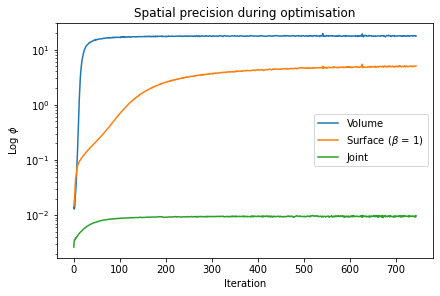

In [14]:
fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=(6,4))
ax.semilogy(vak, label='Volume')
ax.semilogy(sak, label=r'Surface ($\beta$ = 1)')
ax.semilogy(jak, label=r'Joint')
ax.set_xlabel('Iteration')
ax.set_title(r'Spatial precision during optimisation')
ax.legend()
ax.set_ylabel(r'Log $\phi$')
plt.savefig('figs/ak_values.png', dpi=250, bbox_inches='tight')
plt.show()

In [15]:
odir = op.join(SIM_ROOT, 'rpt0_losnr/svb_native')
proj = tob.Projector.load(op.join(odir, 'projector.h5'))

In [16]:
ak = np.loadtxt(op.join(odir, 'ak_ftiss_surf_history.txt'))[:-1]
recon = nib.load(op.join(odir, 'reconstruction_history.nii.gz')).get_fdata()
recon = recon.reshape(-1, recon.shape[-1])
rmask = (proj.cortex_pvs()[...,0] > 0.05 ).flatten()
recon = recon[rmask,:-1].mean(0)

In [17]:
lat = np.load(op.join(odir, 'param_latent_history.npz'))['arr_0']
lat = lat[proj.n_surf_nodes:,:-1].mean(0)

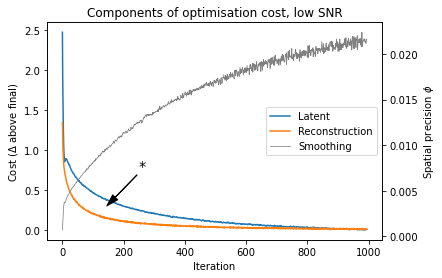

In [31]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

crop = 5 
l = lat[crop:] - lat.min()
r = recon[crop:] - recon.min()
h1, = ax.plot(l, label='Latent')
h2, = ax.plot(r, label='Reconstruction')
ax2 = ax.twinx()
h3, = ax2.plot(ak[crop:], c=cmap[7,:], linewidth=0.75, label=r'Smoothing')

ax.annotate('*', (145,0.3), (250,0.75), fontsize='x-large',
            arrowprops={'facecolor': 'black', 'width': 0.1, 'headwidth': 7})

ax.legend(handles=[h1, h2, h3], loc='center right')
ax.set_title('Components of optimisation cost, low SNR')
ax.set_xlabel('Iteration')
ax.set_ylabel(r'Cost ($\Delta$ above final)')
ax2.set_ylabel(r'Spatial precision $\phi$')
plt.savefig('figs/optimisation_cost.png', dpi=250, bbox_inches='tight')

In [19]:
def ctx_thickness(proj): 
    dists = np.concatenate([
        hemi.outSurf.points - hemi.inSurf.points 
        for hemi in proj.iter_hemis
    ])
    
    return np.linalg.norm(dists, ord=2, axis=-1)

In [20]:
proj_cmn = tob.Projector.load(op.join(SIM_ROOT, 'projector_common.h5'))
ctx_mask = (proj_cmn.cortex_pvs()[...,0] > 0.1)
thick_mask = (ctx_thickness(proj_cmn) > 1)
brain_mask = (proj_cmn.cortex_pvs()[...,1] > 0.1)

svb_cbf = np.zeros((proj_cmn.n_surf_nodes, N_REPEATS, 2))
basil_cbf = np.zeros((*proj_cmn.spc.size, N_REPEATS, 2))
bproj_cbf = np.zeros_like(svb_cbf)
for rpt, snr in itertools.product(range(N_REPEATS), ['losnr', 'hisnr']):
    
    sidx = 0 if snr == 'losnr' else 1 
    sdir = op.join(SIM_ROOT, f'rpt{rpt}_{snr}/svb_native')
    scbf, _, _ = helpers.load_svb_hybrid(sdir)
    svb_cbf[:,rpt,sidx] = scbf[0]
    
    bdir = op.join(SIM_ROOT, f'rpt{rpt}_{snr}/basil_common')
    bcbf = helpers.load_basil(bdir, True)
    basil_cbf[...,rpt,sidx] = bcbf[...,0]
    
    bdir = op.join(SIM_ROOT, f'rpt{rpt}_{snr}/basil_native')
    bcbf = helpers.load_basil_projected(bdir)
    bproj_cbf[:,rpt,sidx] = bcbf
    

In [21]:
# Activation analysis 
rois_surf = rois_flat(proj_cmn['LPS'])

In [22]:
def rois_as_volume(proj):
    rois_surf = rois_flat(proj['LPS'])
    rois_vol = []
    for roi in rois_surf: 
        x = np.ones(proj['LPS'].n_points)
        x[roi] = 2 
        x = np.concatenate([x,x])
        y = proj.surf2vol(x, edge_scale=False).reshape(proj.spc.size)
        y = y > 1.75
        assert y.any()
        rois_vol.append(y)
    rois_vol = np.stack(rois_vol, axis=-1)
    return rois_vol 

rois_vol = rois_as_volume(proj_cmn)
proj_cmn.spc.save_image(rois_vol, 'vol_rois.nii.gz')

In [23]:
svb_z = np.zeros((len(rois_surf), N_REPEATS, 2))
basil_z = np.zeros_like(svb_z)
bproj_z = np.zeros_like(svb_z)
true_z = np.zeros(len(rois_surf))

true_cbf_surf = np.concatenate([
    nibabel.load(p).darrays[0].data
    for p in [
         op.join(SIM_ROOT, 'L_cortex_cbf_truth.func.gii'),
         op.join(SIM_ROOT, 'R_cortex_cbf_truth.func.gii'),
    ]
])

for roi_idx in range(len(rois_surf)):
    rv = rois_vol[...,roi_idx]
    rs = rois_surf[roi_idx]
    
    zscores = stats.zscore(true_cbf_surf)
    true_z[roi_idx] = zscores[rs].mean()
    
#     Do we need to apply extra mask here
    for rpt_idx,snr in itertools.product(range(N_REPEATS), ['losnr', 'hisnr']):
        sidx = 0 if snr == 'losnr' else 1

        zscores = stats.zscore(svb_cbf[:,rpt_idx,sidx])
        svb_z[roi_idx, rpt_idx, sidx] = np.nanmean(zscores[rs])
        
        zscores = stats.zscore(bproj_cbf[:,rpt_idx,sidx])
        bproj_z[roi_idx, rpt_idx, sidx] = np.nanmean(zscores[rs])
        
        m = rv[ctx_mask]
        zscores = stats.zscore(basil_cbf[ctx_mask,rpt_idx,sidx])
        basil_z[roi_idx, rpt_idx, sidx] = np.nanmean(zscores[m])


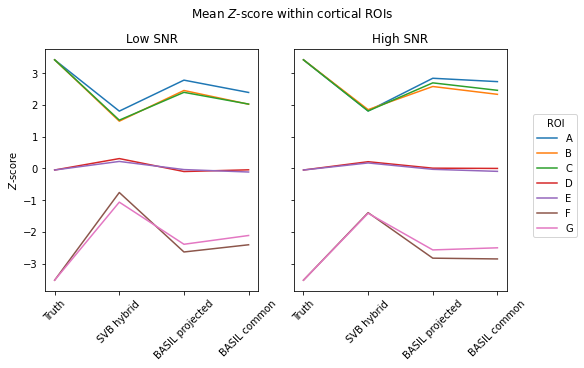

In [24]:
fig, axes = plt.subplots(1,2, constrained_layout=True, sharey=True, figsize=(8,5))

for sidx,(ax,title) in enumerate(zip(axes, ['Low SNR', 'High SNR'])):
    for idx in range(len(rois_surf)):
        y = [ true_z[idx], svb_z[idx,:,sidx].mean(), bproj_z[idx,:,sidx].mean(), basil_z[idx,:,sidx].mean() ]
        ax.plot(y, label=string.ascii_uppercase[idx])
        
    ax.set_title(title)
    ax.set_xticks(range(4))
    ax.set_xticklabels(['Truth', 'SVB hybrid', 'BASIL projected', 'BASIL common'], rotation=45)
    
axes[0].set_ylabel(r'$Z$-score')
ax.legend(title='ROI', bbox_to_anchor=(1.1, 0.75))
fig.suptitle(r'Mean $Z$-score within cortical ROIs')
plt.savefig('figs/roi_zscores.png', dpi=250, bbox_inches='tight')
plt.show()

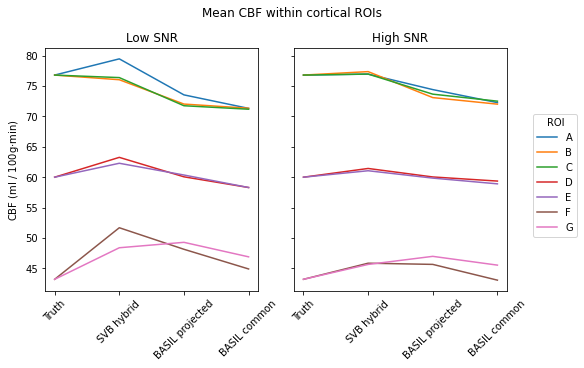

In [25]:
fig, axes = plt.subplots(1,2, constrained_layout=True, sharey=True, figsize=(8,5))

for sidx,(ax,title) in enumerate(zip(axes, ['Low SNR', 'High SNR'])):
    for ridx,(rs,rv) in enumerate(zip(rois_surf, np.rollaxis(rois_vol, 3, 0))):
        
        m = true_cbf_surf[rs].mean()
        s = svb_cbf[rs,:,sidx].mean()
        bp = bproj_cbf[rs,:,sidx].mean()
        bv = basil_cbf[rv,:,sidx].mean()
        
        y = [ m, s, bp, bv ]
        ax.plot(y, label=string.ascii_uppercase[ridx])
        
    ax.set_title(title)
    ax.set_xticks(range(4))
    ax.set_xticklabels(['Truth', 'SVB hybrid', 'BASIL projected', 'BASIL common'], rotation=45)
    
axes[0].set_ylabel(r'CBF (ml / 100g$\cdot$min)')
ax.legend(title='ROI', bbox_to_anchor=(1.1, 0.75))
fig.suptitle('Mean CBF within cortical ROIs')
plt.savefig('figs/roi_cbf.png', dpi=250, bbox_inches='tight')
plt.show()

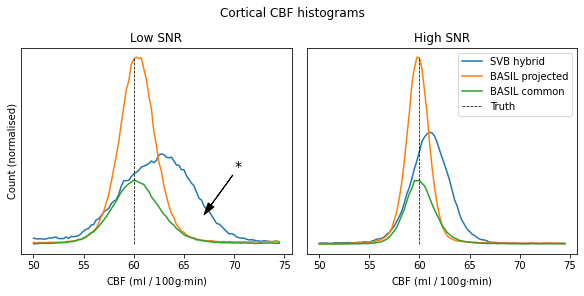

In [26]:
fig, axes = plt.subplots(1,2, constrained_layout=True, figsize=(8,4))

for sidx,(ax,title) in enumerate(zip(axes, ['Low SNR', 'High SNR'])):
        
    bins = np.arange(50,75,0.25)
    sh = np.histogram(svb_cbf[thick_mask,:,sidx], bins)[0]
    ax.plot(bins[:-1], sh, label='SVB hybrid')

    bh = np.histogram(bproj_cbf[thick_mask,:,sidx], bins)[0]
    ax.plot(bins[:-1], bh, label='BASIL projected')
    bmax = max([bh.max(), sh.max()])

    bh = np.histogram(basil_cbf[ctx_mask,:,sidx], bins)[0]    
    ax.plot(bins[:-1], bh, label='BASIL common')
    
    ax.plot([60,60], [0,bmax], 'k--', linewidth=0.75, label='Truth')
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xlabel(r'CBF (ml / 100g$\cdot$min)')
  
axes[0].set_ylabel('Count (normalised)')
ax.legend()
fig.suptitle('Cortical CBF histograms')

axes[0].annotate('*', (67,2e3), (70,5e3), fontsize='x-large',
            arrowprops={'facecolor': 'black', 'width': 0.1, 'headwidth': 7})

plt.savefig('figs/cortex_cbf_hist.png', dpi=250, bbox_inches='tight')
plt.show()

In [27]:
bnative_cbf = np.zeros((*proj_cmn.spc.size, N_REPEATS, 2))
bcommon_cbf = np.zeros_like(bnative_cbf)
svb_cbf = np.zeros_like(bnative_cbf)

for rpt, snr in itertools.product(range(N_REPEATS), ['losnr', 'hisnr']):
    
    sidx = 0 if snr == 'losnr' else 1 
    sdir = op.join(SIM_ROOT, f'rpt{rpt}_{snr}/svb_native')
    scbf = loadnii(op.join(sdir, 'mean_ftiss.nii.gz'))
    svb_cbf[...,rpt,sidx] = scbf
    
    bdir = op.join(SIM_ROOT, f'rpt{rpt}_{snr}/basil_common')
    bcbf = helpers.load_basil(bdir, True)
    bcommon_cbf[...,rpt,sidx] = bcbf[...,1]
    
    bdir = op.join(SIM_ROOT, f'rpt{rpt}_{snr}/basil_native')
    bcbf = helpers.load_basil(bdir, True)
    bnative_cbf[...,rpt,sidx] = bcbf[...,1]
    

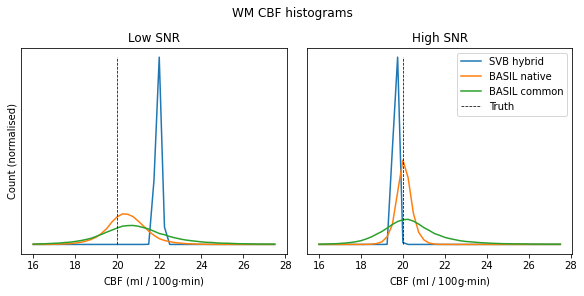

In [28]:
fig, axes = plt.subplots(1,2, constrained_layout=True, sharey=False, figsize=(8,4))

for sidx,(ax,title) in enumerate(zip(axes, ['Low SNR', 'High SNR'])):
    bins = np.arange(16,28,0.25)
    
    sh = np.histogram(svb_cbf[...,sidx], bins)[0]
    ax.plot(bins[:-1], sh, label='SVB hybrid')
    
    bh = np.histogram(bnative_cbf[...,sidx], bins)[0]
    ax.plot(bins[:-1], bh, label='BASIL native')

    bh = np.histogram(bcommon_cbf[...,sidx], bins)[0]
    ax.plot(bins[:-1], bh, label='BASIL common')
        
    ax.plot([20,20], [0,sh.max()], 'k--', linewidth=0.75, label='Truth')
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xlabel(r'CBF (ml / 100g$\cdot$min)')
    
axes[0].set_ylabel(r'Count (normalised)')
ax.legend()
fig.suptitle('WM CBF histograms')
plt.savefig('figs/wm_cbf_dist.png', dpi=250, bbox_inches='tight')
plt.show()